# AUC Hypothesis tests

Suppose you build a predictive model on a small sample. It has a small AUC/ROC. Can you state if it is significantly better than chance?

What is the distribution of ROC/AUC scores under the null hypothesis?

In [1]:
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

Let's start with some functions to generate the AUC of a random model, given a number of points and fraction positive.

I'm defining a **random model** as one for which the ordering of predicted probabilities is independent of the true labels.

In [2]:
def get_auc_sample(y_true):
    '''Generate an AUC from a random model and some actual target'''
    y_score = np.random.choice(np.arange(len(y_true)),
                               len(y_true),
                               replace=False)
    return roc_auc_score(y_true, y_score)

def get_auc_samples(p_pos, n_pts, n_samples):
    n_pos = int(p_pos * n_pts)
    n_neg = n_pts - n_pos
    y_true = np.concatenate([np.zeros(n_neg), np.ones(n_pos)])
    aucs = np.zeros(n_samples)
    for i in range(n_samples):
        aucs[i] = get_auc_sample(y_true)
    return aucs

In [3]:
aucs = get_auc_samples(0.5, 8, 10000)

**Warning:** There's an issue here about getting unique float-point values for some numbers of samples.

In [4]:
def plot_normalized_bars(ax, xs, ys, spacing):
    '''Note that xs are assumed to be unique and sorted'''
    ax.bar(xs,
           ys/ys.sum(),
           width=spacing*0.7)

def plot_aucs(ax, aucs):

    xpts = np.linspace(-0.2, 1.2)


    unique_aucs, counts = np.unique(aucs,
                                    return_counts=True)
    spacing = (unique_aucs[1:] -
               unique_aucs[:-1]).min()
    #print(unique_aucs, counts, spacing)
    ax.plot(xpts, stats.norm(aucs.mean(),
                             aucs.std()).pdf(xpts) * spacing,
                             'k-')
    plot_normalized_bars(ax, unique_aucs, counts, spacing)
    ax.set_xlabel('AUC')
    ax.set_ylabel('Probability')

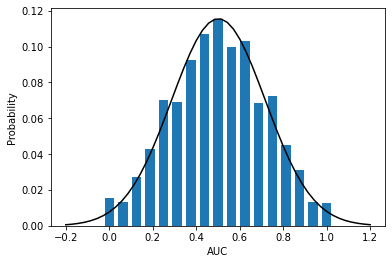

In [5]:
fig, ax = plt.subplots()
plot_aucs(ax, aucs)

Clearly it's not binomial. I'm not sure if this distribution has a name.

Suppose, rather than a train-test split, we're evaluating our model with k-fold cross-validation.

In the naive approach, we take the average of the AUC of the k folds, and compare it the distribution of the average of k AUCs as above.

The problem is that it doesn't account for the relationship between the values, that even if the model is useless, the AUCs calculated on different folds may be more similar to each other than random models.

We may need to understand the distribution of AUCs of a model built under different samples. For a large sample this should be normally distributed.